# Предсказание выживания пассажиров «Титаника»

Крушение «Титаника» — одно из самых печально известных кораблекрушений в истории. 15 апреля 1912 года во время своего первого рейса «Титаник», считавшийся «непотопляемым», затонул после столкновения с айсбергом. К сожалению, спасательных шлюпок на всех на борту не хватило, в результате чего из 2224 пассажиров и членов экипажа погибли 1502 человека. Хотя в выживании был некоторый элемент удачи, кажется, что у некоторых групп людей было больше шансов выжить, чем у других. В этом исследовании мы построим прогностическую модель, отвечающую на вопрос: «У каких людей больше шансов выжить?», используя данные о пассажирах (например, имя, возраст, пол, социально-экономический класс и т.д.).


# Цель исследования

Построить модель предсказания выживания пассажиров.


# Описание данных

Данные разбиты на две группы: тренировочный набор (train.csv) и тестовый набор (test.csv). Оба набора содержат следующие колонки:
- `PassengerId` - идентификационный номер пассажира
- `Survived` - выживание (0 = нет, 1 = да)
- `Pclass` - класс билета (1 = 1-й, 2 = 2-й, 3 = 3-й)
- `Name` - имя
- `Sex` - пол
- `Age` - возраст в годах
- `SibSp` - братьев и сестер/супругов на борту Титаника
- `Parch` - родителей/детей на борту Титаника
- `Ticket` - номер билета
- `Fare` - пассажирский тариф
- `Cabin` - номер каюты
- `Embarked` - порт погрузки (C = Cherbourg, Q = Queenstown, S = Southampton)


# Этапы исследования
1. Обзор данных
1. Анализ данных
2. Предобработка данных
3. Обучение моделей
4. Тестирование лучшей модели

## Обзор данных

In [ ]:
# импортируем нужные библиотеки

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# сохраним обучающую и тестовую выборки в отдельные переменные

train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

In [ ]:
# посмотрим на 10 случайных строк обучающей выборки

train.sample(10)

In [ ]:
# посмотрим на 10 случайных строк тестовой выборки

test.sample(10)

В тестовой выборке закономерно отсутствует колонка `Survived`.

In [ ]:
# посмотрим на размерность данных

print(train.shape)
test.shape

In [ ]:
# взглянем на общую информацию о данных

print('Обучающая выборка:')
print(train.info())
print()
print('Тестовая выборка:')
test.info()

Видно, что есть пропуски в обеих выборках.

In [ ]:
# посчитаем пропуски в данных

print('Число пропусков в обучающей выборке:')
print(train.isna().sum())
print()
print('Число пропусков в тестовой выборке:')
test.isna().sum()

Визуализируем доли пропусков для наглядности. Напишем функцию, которая выводит диаграмму с долями пропусков по убыванию.

In [ ]:
def pass_value_barh(data, title=None):
    try:
        (
            (data.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by='space', ascending=True)
            .plot(kind = 'barh', figsize=(10,7), legend=False, fontsize = 15)
            .set_title(f'Доля пропущенных значений в {title} выборке, %' + "\n", fontsize = 15)
        );
    except:
        print('пропусков не осталось')

In [ ]:
# выведем доли пропущенных значений в обучающей выборке

pass_value_barh(train, 'обучающей')

Почти 80% пропусков в колонке с номером каюты, около 20% в колонке с возрастом и менее 1% в колонке с портом погрузки.

In [ ]:
# выведем доли пропущенных значений в тестовой выборке

pass_value_barh(test,'тестовой')

Практически аналогичная ситуация с номером каюты и возрастом в тестовой выборке, а также менее 1% пропусков в колонке пассажирский тариф.

In [ ]:
# посмотрим на статистические показатели обучающей выборки

train.describe()

In [ ]:
# посмотрим на статистические показатели тестовой выборки

test.describe()

**Вывод**

Данные уже разделены на обучающую и тестовую выборки. Обе выборки содержат пропуски в колонках `Cabin` (около 80%) и `Age` (около 20%). Менее 1% пропусков в колонке `Embarked` обучающей выборки. И менее 1% пропусков в колонке `Fare` тестовой выборки.

## Анализ данных

Посмотрим соотношение выживших и погибших в обучающей выборке.

In [ ]:
plt.figure(figsize=(15, 10))
train['Survived'].value_counts().plot(kind='pie', autopct='%.1f%%')
plt.legend()
plt.title('Доли выживших и погибших', fontsize=15);

Есть некоторый дисбаланс классов. Виживших в обучающей выборке примерно 40%.

In [ ]:
# посмотрим на распределение мужчин и женщин

plt.figure(figsize=(10, 7))
sns.countplot(data=train, x='Sex')
plt.title('Распределение мужчин и женщин', fontsize=15)
plt.xlabel('Пол', fontsize=15)
plt.ylabel('Количество', fontsize=15);

Мужчин было на борту почти в 2 раза больше, если брать только обучающую выборку. Теперь оценим выживание в зависимости от пола.

In [ ]:
plt.figure(figsize=(10, 7))
sns.countplot(data=train, x='Survived', hue='Sex')
plt.title('Выживание в зависимости от пола', fontsize=15)
plt.xlabel('Выживание', fontsize=15)
plt.ylabel('Количество', fontsize=15);

Как видно, женщины имеют больше шансов на выживание.

In [ ]:
# построим распределение классов билетов

plt.figure(figsize=(10, 7))
sns.countplot(data=train, x='Pclass')
plt.title('Распределение классов', fontsize=15)
plt.xlabel('Класс билета', fontsize=15)
plt.ylabel('Количество', fontsize=15);

Представителей 3 класса больше всех, на втором месте - 1 класс и меньше всех пассажиров 2 класса. Теперь оценим шансы выжить в зависимости от класса.

In [ ]:
plt.figure(figsize=(10, 7))
sns.countplot(data=train, x = 'Survived', hue = 'Pclass')
plt.title('Выживание в зависимости от класса билета', fontsize=15)
plt.xlabel('Выживание', fontsize=15)
plt.ylabel('Количество', fontsize=15);

Больше всего погибло людей из 3 класса. Меньше всего - представителей 1 класса, хотя по численности их было не меньше всех. Похоже больше шансов у более богатых пассажиров.

In [ ]:
# построим распределение портов погрузки

plt.figure(figsize=(10, 7))
sns.countplot(data=train, x='Embarked')
plt.title('Распределение портов погрузки', fontsize=15)
plt.xlabel('Порт', fontsize=15)
plt.ylabel('Количество', fontsize=15);

Больше всего людей (более 600) взошло на борт в порту `Southampton`. Меньше всего (менее 100) - в `Queenstown`. И снова посмотрим как порт связан с выживанием.

In [ ]:
plt.figure(figsize=(10, 7))
sns.countplot(data=train, x = 'Survived', hue = 'Embarked')
plt.title('Выживание в зависимости от порта', fontsize=15)
plt.xlabel('Выживание', fontsize=15)
plt.ylabel('Количество', fontsize=15);

Количество и погибших и выживших из разных портов примерно повторяет их изначальное распределение.

In [ ]:
# построим распределение возраста мужчин и женщин

grid = sns.FacetGrid(train, col='Sex', height=6)
grid.map(plt.hist, 'Age', bins=25)
grid.add_legend()
grid.fig.suptitle('Распределение возраста мужчин и женщин')
grid.fig.subplots_adjust(top=0.8);

Заметно много молодых мужчин в возрасте от 20 до 30 лет.

**Вывод**

В обучающей выборке есть небольшой дисбаланс классов: почти 40% выживших. Анализ данных показал, что у женщин и у людей из 1 класса несколько больше шансов выжить.

## Предобработка данных

Удалим колонку `Cabin` из обеих выборок, т.к. пропусков в ней слишком много, а восстановить их проблематично. Плюс ко всему, данная колонка не несет особой ценности. Также удалим колонку `PassengerId`, т.к. это просто порядковый номер пассажира. Колонки `Name` и `Ticket` тоже не представляют пользу.

In [ ]:
train.drop(['Cabin', 'PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
test.drop(['Cabin', 'PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

Заполним пропуски возраста в обучающей выборке медианными значениями с группировкой по полу.

In [ ]:
for sex in train['Sex'].unique(): 
    train.loc[(train['Sex'] == sex) & (train['Age'].isna()), 'Age'] = \
    train.loc[(train['Sex'] == sex), 'Age'].median()

В тестовой выборке также заполним пропуски возраста медианами **обучающей** выборки с группировкой по полу, чтобы избежать утечки данных.

In [ ]:
for sex in test['Sex'].unique(): 
    test.loc[(test['Sex'] == sex) & (test['Age'].isna()), 'Age'] = \
    train.loc[(train['Sex'] == sex), 'Age'].median()

In [ ]:
# удалим оставшиеся пропуски в колонке Embarked обучающей выборки

train = train.dropna()

Пропуск в колонке `Fare` тестовой выборки заполним медианным значением **обучающей** выборки с группировкой по классу билета.

In [ ]:
for c in test['Pclass'].unique(): 
    test.loc[(test['Pclass'] == c) & (test['Fare'].isna()), 'Fare'] = \
    train.loc[(train['Pclass'] == c), 'Fare'].median()

In [ ]:
# снова взглянем на общую информацию о данных

print('Обучающая выборка:')
print(train.info())
print()
print('Тестовая выборка:')
test.info()

Пропусков в данных больше нет.

In [ ]:
train.head()

Перекодируем категориальные переменные `Sex` и `Embarked` в числовой вид. Также стоит отметить, что колонка `Pclass` по пути тоже содержит категориальные значения, поэтому эту колонку тоже перекодируем. Для этого заранее переведем ее значания в строковый формат.


In [ ]:
train['Pclass'] = train['Pclass'].astype('str')
test['Pclass'] = test['Pclass'].astype('str')

In [ ]:
# перекодируем категориальные переменные в числовой вид

train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [ ]:
train.head()


In [ ]:
test.head()

Теперь посмотрим, как признаки коррелируют друг с другом.

In [ ]:
# построим матрицу корреляций признаков

plt.figure(figsize=(16, 12))
sns.heatmap(train.corr(), annot=True)
plt.title('Матрица корреляций признаков'+'\n', fontsize=15);

Из важного для нас: заметнее всего корреляция между выживанием и полом (-0,54 у мужчин, 0,54 у женщин соответственно). То есть, как мы заметили раньше, похоже женщины имеют больше шансов выжить. Также можно заменить слабую отрицательную корреляцию между выживанием и 3 классом билета (-0,32). И наоборот, есть слабая положительная корреляция (0,28) между выживанием и 1 классом. Что опять же подтверждает наше недавнее замечание о том, пассажиры с более дешевым классом билетов имеют меньше шансов выжить.

**Вывод**

Пропуски возраста в обучающей и тестовой выборках заполнили медианными значениями обучающей выборки с группировкой по полу. Пропуск в колонке `Fare` тестовой выборки заполнили медианой обучающей выборки с группировкой по классу билета. От пропусков в колонке `Cabin` избавились, просто удалив колонку: там пропосков слишком много. Также удалили столбцы `PassengerId`, `Name` и `Ticket` как бесполезные. Сделали перекодировку категориальных переменных для подготовки данных к обучению. Матрица корреляции признаков подтвердила, что у женщин и у людей из 1 класса несколько больше шансов выжить.

## Обучение моделей

Подготовим данные к обучению. Разделим обучающую выборку на обучающу и валидационную. Сделаем стратификацию по колонке `Survived`.

In [ ]:
train, valid = train_test_split(train, test_size=0.25, stratify=train['Survived'], random_state=42)

features_train = train.drop(['Survived'], axis=1)
target_train = train.Survived

features_valid = valid.drop(['Survived'], axis=1)
target_valid = valid.Survived

In [ ]:
# масштабируем признаки

scaler = StandardScaler()
scaler.fit(features_train)
features_train[features_train.columns] = scaler.transform(features_train[features_train.columns])
features_valid[features_valid.columns] = scaler.transform(features_valid[features_valid.columns])

In [ ]:
features_train.head()

Напишем функцию для обучения и оценки моделей.

In [ ]:
def model_estimator(model, params, features_train, target_train, features_valid, target_valid, title=None):
    model = RandomizedSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    model.fit(features_train, target_train)
    print('Лучшие гиперпараметры:', model.best_params_)
    model = model.best_estimator_
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    #print(classification_report(target_valid, predictions))
    f1 = round(f1_score(target_valid, predictions),2)
    acc = round(accuracy_score(target_valid, predictions), 2)
    roc_auc = round(roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1]),2)
    print('F1:', f1)
    print('Accuracy:', acc)
    print('ROC AUC:', roc_auc)
          
    fpr, tpr, thresholds = roc_curve(target_valid, model.predict_proba(features_valid)[:, 1])
    plt.figure(figsize=(8,5))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim(0,1) 
    plt.ylim(0,1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f'ROC-кривая для {title}', fontsize=15)
    plt.show();
          
    plt.figure(figsize=(10,7))
    sns.heatmap(confusion_matrix(target_valid, predictions, normalize='true'), annot=True, fmt='.0%')
    plt.title(f'Матрица ошибок для {title}', fontsize=15)
    plt.ylabel('Реальные значения')
    plt.xlabel('Предсказанные значения');
    
    return f1, acc, roc_auc

Протестируем разные модели.

**Дерево решений**

In [ ]:
dt = RandomForestClassifier(random_state=12345)
dt_params = {'criterion': ['gini', 'entropy'], 'max_depth': range(1, 30)}
dt = model_estimator(dt, dt_params, features_train, target_train, features_valid, target_valid, 'Дерева решений')

**Случайный лес**

In [ ]:
rf = RandomForestClassifier(random_state=12345)
rf_params = {'n_estimators': [10, 50, 100, 200], 'criterion': ['gini', 'entropy'], 'max_depth': range(1, 30)}
rf = model_estimator(rf, rf_params, features_train, target_train, features_valid, target_valid, 'Случайного леса')

**Логистическая регрессия**

In [ ]:
lg = LogisticRegression(random_state=12345)
lg_params = {'class_weight':['balanced', None], 'max_iter':[500,1000], 'C':[1.0, 3.0]}
lg = model_estimator(lg, lg_params, features_train, target_train, features_valid, target_valid, 'Логистической регресии')

**Стохастический градиентный спуск**

In [ ]:
sgd = SGDClassifier(random_state=12345, loss='log')
sgd_params = {'class_weight':['balanced', None], 'max_iter':[500,1000], 'learning_rate':['optimal', 'adaptive']}
sgd = model_estimator(sgd, sgd_params, features_train, target_train, features_valid, target_valid, 'Стохастического градиентного спуска')

**LightGBM**

In [ ]:
lgbm = LGBMClassifier(random_state=12345)
lgbm_params = {'n_estimators': [10, 50, 100], 'max_depth': range(1, 30), 'learning_rate':[0.01, 0.05, 0.1]}
lgbm = model_estimator(lgbm, lgbm_params, features_train, target_train, features_valid, target_valid, 'LightGBM')

**CatBoost**

In [ ]:
cb = CatBoostClassifier(random_state=12345, verbose=0)
cb_params = {'learning_rate':[0.01, 0.05, 0.1], 'iterations': [100, 200, 500], 'depth': [4, 6, 10]}
cb = model_estimator(cb, cb_params, features_train, target_train, features_valid, target_valid, 'CatBoost')

**XGBoost**

In [ ]:
xgb = XGBClassifier(random_state=12345)
xgb_params = {'n_estimators': [10, 50, 100], 'max_depth': range(1, 30), 'learning_rate':[0.01, 0.05, 0.1]}
xgb = model_estimator(xgb, xgb_params, features_train, target_train, features_valid, target_valid, 'XGBoost')

**Глупая модель**

In [ ]:
dummy = DummyClassifier(random_state=12345)
dummy_params = {'strategy': ['most_frequent', 'prior', 'stratified', 'uniform']}
dummy = model_estimator(dummy, dummy_params, features_train, target_train, features_valid, target_valid, 'Глупой модели')

Построим сводную таблицу с результатами всех моделей.

In [ ]:
models_results = pd.DataFrame([dt, rf, lg, sgd, lgbm, cb, xgb, dummy], 
             columns=['F1', 'Accuracy', 'ROC AUC'], 
             index=['Дерево решений', 'Случайный лес', \
                    'Логистическая регрессия', 'SGD', \
                    'LightGBM', 'CatBoost', 'XGBoost', 'Глупая модель'])
models_results

**Вывод**

По точности и F1 выигрывает модель **LightGBM**. Ее и будем использовать для дальнейшего решения задачи.

## Тестирование лучшей модели

In [ ]:
# соединим обучающую и валидационную выборку 
# для обучения модели на полных данных 

features_train = pd.concat([features_train, features_valid], ignore_index=True)
target_train = pd.concat([target_train, target_valid], ignore_index=True)

In [ ]:
lgbm = LGBMClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=12345)
lgbm.fit(features_train, target_train)
imp = pd.DataFrame(lgbm.feature_importances_/100, index=features_train.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8));

In [ ]:
# подготовим предсказанные значения для загрузки в турнирную таблицу

submission = pd.DataFrame()
submission['PassengerId'] = pd.read_csv('../input/titanic/test.csv')['PassengerId']
submission['Survived'] = lgbm.predict(test)
submission.to_csv('./submission.csv', index=False)

Результат загрузки: точность 0.77.
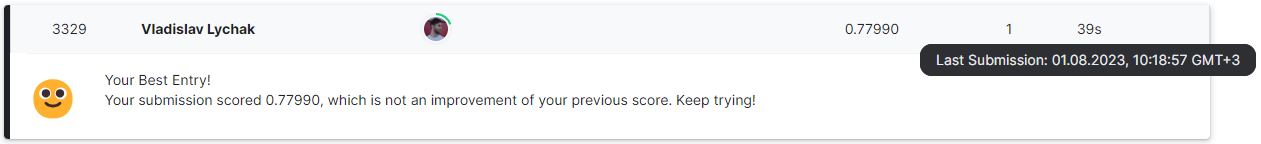

**Вывод**

Точность лучшей модели на тестовой выборке 0.77. Наиболее важными признаками для предсказания выживания пассажиров оказались пассажирский тариф, возраст, число братьев/сестер/супругов на борту, пол.

## Общий вывод

Данные уже разделены были на обучающую и тестовую выборки. Обе выборки содержали пропуски в колонках `Cabin` (около 80%) и `Age` (около 20%). Менее 1% пропусков в колонке `Embarked` обучающей выборки. И менее 1% пропусков в колонке `Fare` тестовой выборки. В обучающей выборке был небольшой дисбаланс классов: почти 40% выживших. Анализ данных показал, что у женщин и у людей из 1 класса несколько больше шансов выжить. Матрица корреляции признаков это подтвердила. Пропуски возраста в обучающей и тестовой выборках заполнили медианными значениями обучающей выборки с группировкой по полу. Пропуск в колонке `Fare` тестовой выборки заполнили медианой обучающей выборки с группировкой по классу билета. От пропусков в колонке `Cabin` избавились, просто удалив колонку: там пропосков слишком много. Также удалили столбцы `PassengerId`, `Name` и `Ticket` как бесполезные. Сделали перекодировку категориальных переменных для подготовки данных к обучению. Обучили и сравнили модели Дерева решений, Случайного леса, Логистической регрессии,  Стохастического градиентного спуска, LightGBM, CatBoost, XGBoost, Глупую модель. Лучшей оказалась модель **LightGBM** (F1 = 0.77, Accuracy = 0.83). Точность на тестовой выборке 0.77. Наиболее важными признаками для предсказания выживания пассажиров оказались пассажирский тариф, возраст, число братьев/сестер/супругов на борту, пол.